In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2
from tensorflow.keras import layers
from keras.models import Model, Sequential
from tensorflow.keras.applications import VGG19
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, LeakyReLU
from keras.layers import Conv2DTranspose, Dropout, ReLU, Input, Concatenate, ZeroPadding2D
from keras.optimizers import Adam
from keras.utils import plot_model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("No GPU devices found. Make sure your GPU is properly installed and configured.")
else:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU configured successfully.")

GPU configured successfully.


In [3]:
import tensorflow as tf

# Check available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate GPU memory growth
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU memory growth set to True")
    except RuntimeError as e:
        print(e)

GPU memory growth set to True


In [4]:
import tensorflow as tf

# Check if TensorFlow can access GPU
num_gpus = len(tf.config.experimental.list_physical_devices('GPU'))

if num_gpus > 0:
    print("Num GPUs Available: ", num_gpus)
    print("TensorFlow is using GPU.")
else:
    print("No GPU available. TensorFlow is using CPU.")

Num GPUs Available:  1
TensorFlow is using GPU.


In [5]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image,tf.float32)
    return image

In [6]:
path = "/kaggle/input/coco2017/"
x = load(os.path.join(path, 'train2017/train2017/000000000072.jpg'))
print(x.shape)

(640, 427, 3)


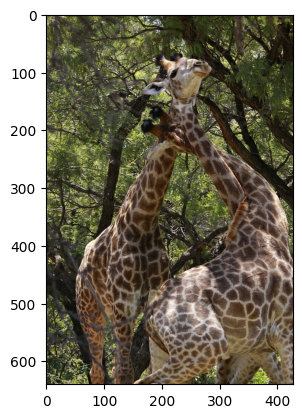

In [7]:
plt.imshow(x/255.0)

In [8]:
def normalize(real_image):
    real_image = (real_image / 255)
    return real_image

In [9]:
def random_crop(real_image):
    cropped_image = tf.image.random_crop(real_image, size = [256, 256, 3])
    return cropped_image

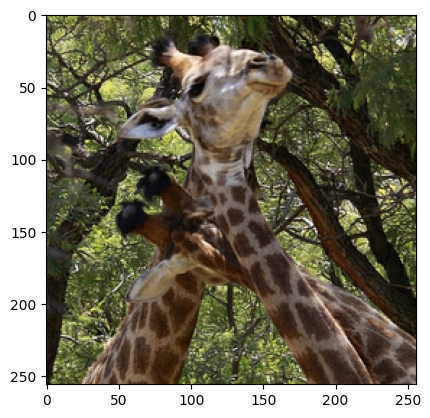

In [10]:
x_aug = random_crop(x)
plt.imshow(x_aug/255.0)

In [11]:
def resize(real_image):
    real_image = tf.image.resize(real_image, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return real_image

In [12]:
def rotate_image(image, angles, interpolation='BILINEAR'):
    """
    Rotate an image tensor by specified angles.

    Args:
    - image: Input image tensor with shape (batch_size, height, width, channels).
    - angles: Tensor of rotation angles in radians for each image in the batch.
    - interpolation: Interpolation method ('BILINEAR' or 'NEAREST').

    Returns:
    - Rotated image tensor.
    """
    batch_size, height, width, channels = tf.unstack(tf.shape(image))

    # Coordinates of the center of the image
    center_x = tf.cast(width, tf.float32) / 2.0
    center_y = tf.cast(height, tf.float32) / 2.0

    # Define transformation matrix
    rotation_matrix = tf.reshape(tf.stack([tf.cos(angles), -tf.sin(angles), center_x * (1 - tf.cos(angles)) + center_y * tf.sin(angles),
                                           tf.sin(angles), tf.cos(angles), -center_x * tf.sin(angles) + center_y * (1 - tf.cos(angles)),
                                           0.0, 0.0, 1.0], axis=1), shape=(-1, 3, 3))

    # Apply rotation to each pixel
    rotated_image = tfa.image.transform(image, rotation_matrix, interpolation)

    return rotated_image


In [13]:
def random_jitter(real_image):
    if tf.random.uniform(()) > 0.5:
        real_image = tf.image.flip_left_right(real_image)
    return real_image

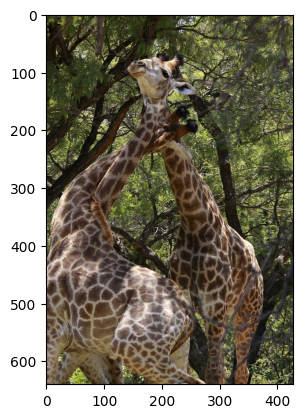

In [14]:
x_jitter = random_jitter(x)
plt.imshow(x_jitter/255.0)

In [15]:
def resize_with_aspect_ratio(image, constant_size):
        # Get image dimensions
        height, width = tf.shape(image)[0], tf.shape(image)[1]

        # Calculate aspect ratio
        aspect_ratio = tf.cast(width, tf.float32) / tf.cast(height, tf.float32)

        # Determine new dimensions based on constant size
        new_height = tf.cond(aspect_ratio >= 1.0,
                             lambda: constant_size,
                             lambda: tf.cast(constant_size / aspect_ratio, tf.int32))
        new_width = tf.cond(aspect_ratio >= 1.0,
                            lambda: tf.cast(constant_size * aspect_ratio, tf.int32),
                            lambda: constant_size)

        # Resize the image
        resized_image = tf.image.resize(image, [new_height, new_width])

        return resized_image

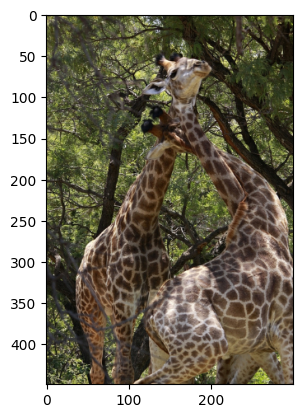

In [16]:
plt.imshow(resize_with_aspect_ratio(x,300)/255)

In [17]:
def load_train_images(image_path):
    real_image = load(image_path)
    real_image = resize_with_aspect_ratio(real_image, 300)
#     real_image = tf.image.resize(real_image, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.random_brightness(real_image, 0.2)
    real_image = random_crop(real_image)
    # Define the rotation angle in radians
    rotation_angle = tf.constant(20.0 * (3.141592653589793 / 180.0), dtype=tf.float32)

    # Apply the rotation using tfa.image.rotate
    real_image = tfa.image.rotate(real_image, angles=rotation_angle)

#     # Example usage
#     angles = tf.placeholder(dtype=tf.float32, shape=(None,))
#     # Specify the rotation range in degrees
#     rotation_range = 15  # Adjust this value as needed
#     # Convert the rotation range to radians
#     rotation_range_rad = rotation_range * (np.pi / 180.0)
#     # Generate random rotation angles for each image in the batch
#     random_angles = tf.random.uniform(shape=(tf.shape(image)[0],), minval=-rotation_range_rad, maxval=rotation_range_rad)
#     # Apply custom rotation to the image with bilinear interpolation
#     real_image = rotate_image(real_image, random_angles, interpolation='BILINEAR')
    #     real_image = rotate(real_image)
    real_image = random_jitter(real_image)
    real_image = normalize(real_image)
    yuv_image = tf.image.rgb_to_yuv(real_image)
    # Separate LAB into L and AB components
    Y_channel = tf.expand_dims(yuv_image[:, :, 0], axis=-1)  # L channel
    UV_channels = yuv_image[:, :, 1:]  # AB channels
    #here L_channel becomes input i.e light/luminance of pixel and AB_channels become target
    return Y_channel, UV_channels

In [18]:
def load_test_image(image_path):
    real_image = load(image_path)
    real_image = resize_with_aspect_ratio(real_image, 256)
#     real_image = tf.image.resize(real_image, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
#     real_image = tf.image.random_brightness(real_image, 0.2)
    real_image = random_crop(real_image)
    real_image = normalize(real_image)
    yuv_image = tf.image.rgb_to_yuv(real_image)
    # Separate LAB into L and AB components
    Y_channel = tf.expand_dims(yuv_image[:, :, 0], axis=-1)  # L channel
    UV_channels = yuv_image[:, :, 1:]  # AB channels
    #here L_channel becomes input i.e light/luminance of pixel and AB_channels become target
    return Y_channel, UV_channels

In [19]:
IMAGE_SIZE = 256
BATCH_SIZE = 16

In [20]:
# create input pipeline
train_dataset = tf.data.Dataset.list_files(path + "train2017/train2017/*.jpg")
train_dataset = train_dataset.map(load_train_images)
train_dataset = train_dataset.take(20000)
train_dataset = train_dataset.shuffle(10).batch(BATCH_SIZE)
train_dataset.cardinality().numpy()

1250

In [21]:
# create input pipeline
val = tf.data.Dataset.list_files(path + "val2017/val2017/*.jpg")
val = val.map(load_test_image)
val = val.take(2500)
val = val.shuffle(10).batch(BATCH_SIZE)
val.cardinality().numpy()

157

In [22]:
# test_dataset = tf.data.Dataset.list_files(path + 'test/*.jpg')
# test_dataset = test_dataset.map(load_test_image)
# test_dataset = test_dataset.batch(1)
# test_dataset

In [23]:
# downsample block
def downsample(filters, size,dropout=False, batchnorm = True):
    init = tf.random_normal_initializer(0.,0.02)
    result = Sequential()
    result.add(Conv2D(filters, size, strides = 2, padding = "same", kernel_initializer = init, use_bias = False))
    if batchnorm == True:
        result.add(BatchNormalization())
    if dropout == True :
        result.add(Dropout(0.3))
    result.add(LeakyReLU())
    return result
down_model = downsample(3,4)
down_result = down_model(tf.expand_dims(x, axis = 0))
print(down_result.shape)

(1, 320, 214, 3)


In [24]:
# upsample block
def upsample(filters, size, dropout = False):
    init = tf.random_normal_initializer(0, 0.02)
    result = Sequential()
    result.add(Conv2DTranspose(filters, size, strides = 2, padding = "same", kernel_initializer = init, use_bias = False))
    result.add(BatchNormalization())
    if dropout == True:
        result.add(Dropout(0.3))
    result.add(ReLU())
    return result
up_model = upsample(3,4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 640, 428, 3)


In [25]:
def generator(input_shape = (256,256,1), output_channels = 2):
    inputs = Input(shape = input_shape)
    down_stack = [
        downsample(32, 4, batchnorm=False),
        downsample(64, 4),
        downsample(128, 4),
        downsample(256, 4, dropout = True),
        downsample(512, 4, dropout = True)
    ]


    up_stack = [
        upsample(512, 4, dropout=True),
        upsample(256, 4, dropout=True),
        upsample(128, 4, dropout=True),
        upsample(64, 4),
        upsample(32, 4),
    ]
    init = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(2, 4, strides = 2, padding = "same", kernel_initializer = init, activation ="tanh")
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])

    x = last(x)
    return Model(inputs = inputs, outputs = x)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 128, 128, 32)         512       ['input_1[0][0]']             
                                                                                                  
 sequential_3 (Sequential)   (None, 64, 64, 64)           33024     ['sequential_2[0][0]']        
                                                                                                  
 sequential_4 (Sequential)   (None, 32, 32, 128)          131584    ['sequential_3[0][0]']        
                                                                                              

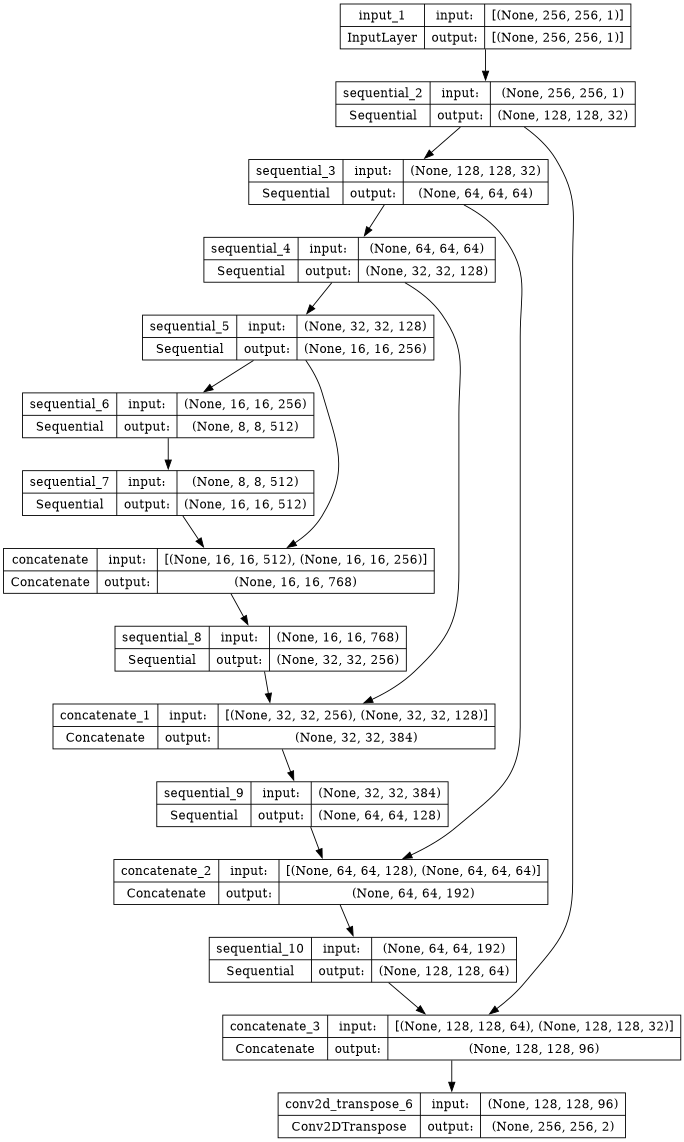

In [26]:
gen = generator()
gen.summary()
plot_model(gen, show_shapes=True, dpi = 64)

In [27]:
# gen.load_weights('/kaggle/input/imagenetmodelweights/gen_weight.keras')

In [28]:
def discriminator():
    init = tf.random_normal_initializer(0., 0.02)

    inp = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 1], name = "input_image")
    tar = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 2], name = "target_image")
    x = Concatenate()([inp, tar])
    down1 = downsample(64,4,False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = ZeroPadding2D()(down3)
    conv = Conv2D(256, 4, strides = 1, kernel_initializer = init, use_bias = False)(zero_pad1)
    leaky_relu = LeakyReLU()(conv)
    zero_pad2 = ZeroPadding2D()(leaky_relu)
    last = Conv2D(1, 4, strides = 1, kernel_initializer=init)(zero_pad2)
    return Model(inputs = [inp, tar], outputs = last)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 target_image (InputLayer)   [(None, 256, 256, 2)]        0         []                            
                                                                                                  
 concatenate_4 (Concatenate  (None, 256, 256, 3)          0         ['input_image[0][0]',         
 )                                                                   'target_image[0][0]']        
                                                                                                  
 sequential_12 (Sequential)  (None, 128, 128, 64)         3328      ['concatenate_4[0][0]'] 

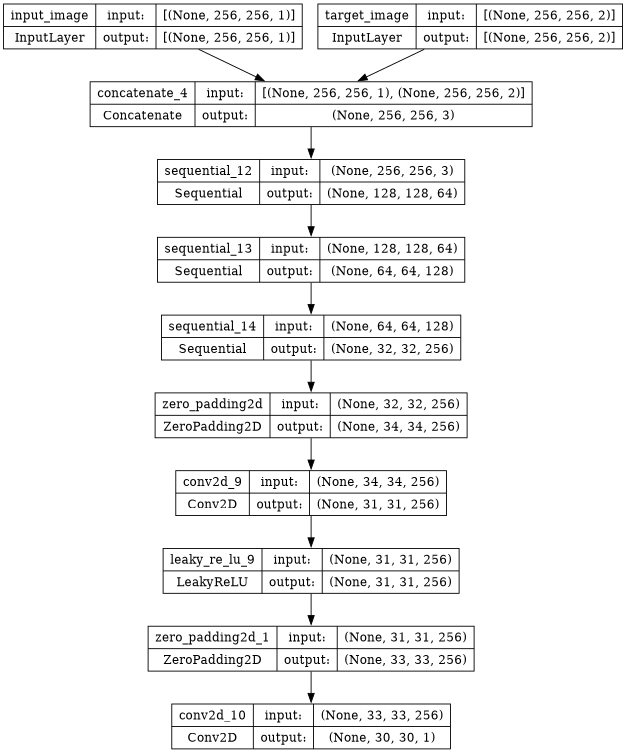

In [29]:
disc = discriminator()
disc.summary()
plot_model(disc, show_shapes=True, dpi = 64)

In [30]:
# disc.load_weights('/kaggle/input/imagenetmodelweights/disc_weight.keras')

In [31]:
# Function to create YUV image from Y, U, and V channels and then convert to rgb
def create_rgb_image(y_channel, uv_channel):
    # Assuming YUV format where Y, U, and V channels are separate
    # y_channel = np.array(y_channel)
    # uv_channel = np.array(uv_channel)
    u_channel, v_channel = tf.split(uv_channel, num_or_size_splits=2, axis=-1)

    # Combine Y, U, and V channels into a YUV image
    rgb_image = tf.image.yuv_to_rgb(tf.concat([y_channel, u_channel, v_channel], axis=-1))
    return rgb_image


In [32]:
LAMBDA = 100

In [33]:
# Define the perceptual loss function
def perceptual_loss(y_true, y_pred):
    vgg = VGG19(include_top=False, weights='imagenet', input_shape=(None, None, 3))
    vgg.trainable = False
    for layer in vgg.layers:
        layer.trainable = False
    model = Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv4').output)
    model.trainable = False

    y_true_features = model(y_true)
    y_pred_features = model(y_pred)

    return tf.reduce_mean(tf.square(y_true_features - y_pred_features))

In [34]:
def generator_loss(disc_generated_output,input_, gen_output, target):
    gan_loss = loss_function(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    p_loss = perceptual_loss(create_rgb_image(input_, gen_output), create_rgb_image(input_, target))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss) + 80*p_loss
    return total_gen_loss, gan_loss, l1_loss, p_loss

In [35]:
from keras.losses import BinaryCrossentropy
loss_function = BinaryCrossentropy(from_logits=True)

In [36]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_function(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_function(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss, real_loss, generated_loss

In [37]:
generator_optimizer = Adam(lr= 2e-4, beta_1=0.5)
discriminator_optimizer = Adam(lr = 2e-4, beta_1=0.5)

In [38]:
epochs = 250

In [39]:
# import tensorflow as tf
# from tensorflow.keras.applications import VGG19
# from tensorflow.keras.models import Model

# # Load the VGG19 model
# vgg = VGG19(weights='imagenet', include_top=False)

# # Select the layers you want to use for the LPIPS score
# selected_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1']

# # Create a model that outputs the selected layers
# outputs = [vgg.get_layer(name).output for name in selected_layers]
# model = Model(inputs=vgg.input, outputs=outputs)

# # Make sure the VGG model is not trainable
# model.trainable = False

# def lpips_score(image1, image2):
#     # Get the features for both images
#     image1_features = model(image1)
#     image2_features = model(image2)

#     # Initialize the score
#     score = 0

#     # For each feature layer...
#     for f1, f2 in zip(image1_features, image2_features):
#         # ... compute the mean squared error between the features
#         mse = tf.reduce_mean((f1 - f2)**2)
#         # ... and add it to the score
#         score += mse

#     return score

In [40]:
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# from scipy.linalg import sqrtm

# # Load the pre-trained InceptionV3 model (weights will be downloaded if not present)
# pretrained_model = InceptionV3(weights='imagenet', include_top=True, pooling='avg')

# # Optionally, you can freeze the layers to prevent training
# for layer in pretrained_model.layers:
#     layer.trainable = False


# # Create a new model to extract features from an intermediate layer
# inception_model = tf.keras.Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer('avg_pool').input)
# def calculate_fid_score(images1, images2, inception_model):
#     # Ensure the batch dimension is removed for individual image predictions
#     images1 = np.squeeze(images1, axis=0)
#     images2 = np.squeeze(images2, axis=0)
    
#     # Resize images to the required size for the Inception model
#     images1 = tf.image.resize(images1, size=(299, 299))
#     images2 = tf.image.resize(images2, size=(299, 299))
    
#     # Extract features using the Inception model
#     features1 = inception_model.predict(np.expand_dims(images1, axis=0))
#     features2 = inception_model.predict(np.expand_dims(images2, axis=0))

#     # Remove batch dimension from features
#     features1 = np.squeeze(features1, axis=0)
#     features2 = np.squeeze(features2, axis=0)
#     #print(features1.shape)
#     # Calculate mean and covariance of feature representations
#     mean1 = np.mean(features1, axis=(0, 1, 2))
#     mean2 = np.mean(features2, axis=(0, 1, 2))
#     #print(features1.shape)
#     cov1 = np.cov(features1.transpose(2, 0, 1).reshape(features1.shape[-1], -1), rowvar=False)
#     cov2 = np.cov(features2.transpose(2, 0, 1).reshape(features2.shape[-1], -1), rowvar=False)
#     #print(cov2.shape)

#     # Calculate the squared Euclidean distance between means
#     sum_squared_diff = np.sum((mean1 - mean2)**2)

#     # Calculate the trace of the product of covariances
#     cov_sqrt = sqrtm(np.dot(cov1, cov2))
#     trace_cov_product = np.trace(cov1 + cov2 - 2 * cov_sqrt)

#     # Calculate FID score
#     fid_score = np.real(sum_squared_diff + trace_cov_product)
    
#     return fid_score

In [41]:
@tf.function
def train_step(input_image, target, epoch, training_discriminator):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = gen(input_image, training=True)
        disc_real_output = disc([input_image, target], training=True)
        disc_generated_output = disc([input_image, gen_output], training=True)
        gen_total_loss, gen_gan_loss, gen_l1_loss, gen_p_loss = generator_loss(disc_generated_output,input_image, gen_output, target)
        disc_loss, disc_real_loss, disc_generated_loss = discriminator_loss(disc_real_output, disc_generated_output)
#         rgb_target = create_rgb_image(input_image, target)
#         rgb_generated = create_rgb_image(input_image, gen_output)
#         ssim_values = tf.image.ssim(rgb_target, rgb_generated, max_val=1.0)
#         psnr_values = tf.image.psnr(rgb_target, rgb_generated, max_val=1.0)
#         lpips_values = lpips_score(rgb_target, rgb_generated)

        if epoch > 8:
            if training_discriminator:
                discriminator_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)
                discriminator_optimizer.apply_gradients(zip(discriminator_gradients, disc.trainable_variables))
            else:
                generator_gradients = gen_tape.gradient(gen_total_loss, gen.trainable_variables)
                generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
        else:
            generator_gradients = gen_tape.gradient(gen_total_loss, gen.trainable_variables)
            discriminator_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)
            generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(discriminator_gradients, disc.trainable_variables))

        return gen_total_loss, gen_gan_loss, gen_l1_loss,gen_p_loss, disc_loss,disc_real_loss, disc_generated_loss, tf.constant([0]), tf.constant([0]), tf.constant([0])

In [42]:
@tf.function
def validation_step(input_image, target):
    # Generate output using the generator
    gen_output = gen(input_image)

    # Calculate losses without updating gradients
    disc_real_output = disc([input_image, target])
    disc_generated_output = disc([input_image, gen_output])

    gen_total_loss, gen_gan_loss, gen_l1_loss, gen_p_loss = generator_loss(disc_generated_output,input_image, gen_output, target)
    disc_loss,disc_real_loss, disc_generated_loss = discriminator_loss(disc_real_output, disc_generated_output)
    rgb_target = create_rgb_image(input_image, target)
    rgb_generated = create_rgb_image(input_image, gen_output)
    ssim_values = tf.image.ssim(rgb_target, rgb_generated, max_val=1.0)
    psnr_values = tf.image.psnr(rgb_target, rgb_generated, max_val=1.0)
#     lpips_values = lpips_score(rgb_target, rgb_generated)
    #accuracy = calculate_accuracy(disc_generated_output, disc_real_output)
    return gen_total_loss, gen_gan_loss, gen_l1_loss,gen_p_loss, disc_loss,disc_real_loss, disc_generated_loss, ssim_values, tf.constant([0]), tf.constant([0])

In [43]:
# @tf.function
# def test_step(input_image, target):
#     # Generate output using the generator
#     gen_output = gen(input_image)

#     # Calculate losses without updating gradients
#     disc_real_output = disc([input_image, target])
#     disc_generated_output = disc([input_image, gen_output])

#     gen_total_loss, gen_gan_loss, gen_l1_loss, gen_p_loss = generator_loss(disc_generated_output,input_image, gen_output, target)
#     disc_loss,disc_real_loss, disc_generated_loss = discriminator_loss(disc_real_output, disc_generated_output)
#     rgb_target = create_rgb_image(input_image, target)
#     rgb_generated = create_rgb_image(input_image, gen_output)
#     ssim_values = tf.image.ssim(rgb_target, rgb_generated, max_val=1.0)
#     psnr_values = tf.image.psnr(rgb_target, rgb_generated, max_val=1.0)
#     lpips_values = lpips_score(rgb_target, rgb_generated)
#     fid_values = calculate_fid_score(rgb_target, rgb_generated, inception_model)
#     #accuracy = calculate_accuracy(disc_generated_output, disc_real_output)
#     return gen_total_loss, gen_gan_loss, gen_l1_loss,gen_p_loss, disc_loss,disc_real_loss, disc_generated_loss, ssim_values, psnr_values, lpips_values, fid_values


In [44]:
os.mkdir('/kaggle/working/gen_output/')

In [45]:
def display_one_random_test_image(input_, target, gen_model, epoch):
    print("Displaying one random test image...")
    img_array = np.array(input_)
    generated_output_test = gen_model(input_)
    ssim = tf.image.ssim(tf.reshape(create_rgb_image(input_, target), (256,256,3)), tf.reshape(create_rgb_image(input_,generated_output_test), (256,256,3)), max_val=1.0)
    psnr = tf.image.psnr(tf.reshape(create_rgb_image(input_, target), (256,256,3)), tf.reshape(create_rgb_image(input_,generated_output_test), (256,256,3)), max_val=1.0)  
#     lpips = lpips_score(tf.reshape(create_rgb_image(input_, target), (1,256,256,3)), tf.reshape(create_rgb_image(input_,generated_output_test), (1,256,256,3)))
#     p_loss = perceptual_loss(create_rgb_image(input_, target), create_rgb_image(input_, generated_output_test))
#     fid_score = calculate_fid_score(tf.reshape(create_rgb_image(input_, target), (1,256,256,3)), tf.reshape(create_rgb_image(input_,generated_output_test), (1,256,256,3)), inception_model)
    # print(input_.shape)
    input_ = np.squeeze(input_, axis=0)
    # print(type(input_), type(target))
    # print(input_.shape, input_)
    # input_.reshape((256,256))
    plt.figure(figsize=(16, 16))
    plt.subplot(1, 4, 1)
    plt.title('Input Testing Image')
    plt.imshow(input_, cmap='gray', vmax = 1, vmin = 0)  # Assuming images are normalized to [0, 1]
    plt.axis('off')
    # # print(target.shape)
    target = np.squeeze(target, axis=0)
    # # print(target.shape)
    target_img = create_rgb_image(input_, target).numpy()
    # # print(type(target_img))
    # target
    # # print(target_img.shape, target_img)
    plt.subplot(1, 4, 2)
    plt.title('Target Testing Image')
    plt.imshow(target_img)  # Assuming images are normalized to [0, 1]
    plt.axis('off')
    # # Convert PIL Image to NumPy array
    # img_array = np.array(input_)
    # # Add batch dimension
    # # print(img_array.shape)
    # img_array = np.expand_dims(img_array, axis=0)
    # # print(img_array.shape)
    # generated_output_test = gen_model(img_array)
    # # print(generated_output_test.shape)
    # # Squeeze the singleton dimension
    generated_output_test = np.squeeze(generated_output_test, axis=0)
    # # print(generated_output_test.shape)
    generated_img = create_rgb_image(input_, generated_output_test).numpy()
    # # print(generated_img.shape, generated_img)
    plt.subplot(1, 4, 3)
    plt.title(f'Generated Output -- epoch {epoch}')
    plt.imshow(generated_img)  # Assuming images are normalized to [-1, 1]
    plt.axis('off')
    plt.savefig(f'/kaggle/working/gen_output/epoch_{epoch}.png')
    plt.show()
    print('SSIM Score: {}'.format(ssim))
    print('PSNR Score: {}'.format(psnr))
#     print('LPIPS Score: {}'.format(lpips))
#     print('Perceptual Loss: {}'.format(p_loss))
#     print('FID Score: {}'.format(fid_score))

In [46]:
def display_random_test_image(gen_model, image_path, epoch):
    
    real_image = load(image_path)
    real_image = resize(real_image)
    real_image = normalize(real_image)
    yuv_image = tf.image.rgb_to_yuv(real_image)
    # Separate LAB into L and AB components
    Y_channel = tf.expand_dims(yuv_image[:, :, 0], axis=-1)  # L channel
    UV_channels = yuv_image[:, :, 1:] 

    # Display the image
    display_one_random_test_image(tf.reshape(Y_channel, (1,256,256,1)),tf.reshape(UV_channels,(1,256,256,2)), gen_model, epoch)


Displaying one random test image...


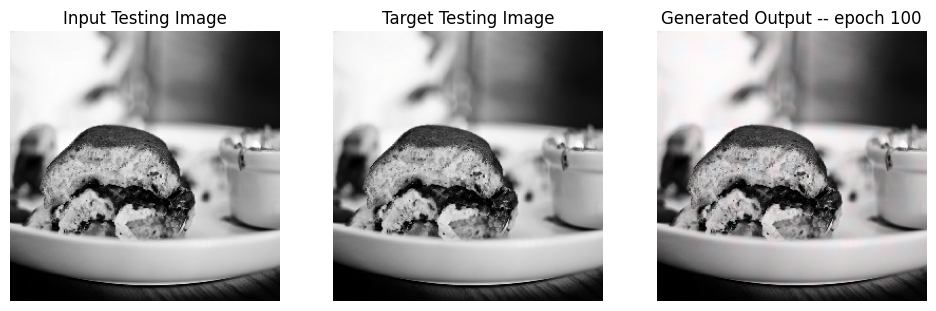

SSIM Score: 0.9712417721748352
PSNR Score: 41.16259002685547


In [47]:
display_random_test_image(gen, '/kaggle/input/coco2017/val2017/val2017/000000001425.jpg',100)

In [48]:
import random

each_epoch_train_generator_losses = []
each_epoch_train_generator_gan_losses = []
each_epoch_train_generator_l1_losses = []
each_epoch_train_generator_l2_losses = []
each_epoch_train_generator_perceptual_losses = []
each_epoch_train_discriminator_losses = []
each_epoch_train_discriminator_real_losses = []
each_epoch_train_discriminator_generated_losses = []
each_epoch_train_ssim = []
each_epoch_train_psnr = []
each_epoch_train_lpips = []
each_epoch_test_lpips = []
each_epoch_test_psnr = []
each_epoch_test_ssim = []
each_epoch_test_generator_losses = []
each_epoch_test_generator_gan_losses = []
each_epoch_test_generator_l1_losses = []
each_epoch_test_generator_l2_losses = []
each_epoch_test_generator_perceptual_losses = []
each_epoch_test_discriminator_losses = []
each_epoch_test_discriminator_real_losses = []
each_epoch_test_discriminator_generated_losses = []
train_generator_losses = []
train_generator_gan_losses = []
train_generator_l1_losses = []
train_generator_l2_losses = []
train_generator_perceptual_losses = []
train_discriminator_losses = []
train_discriminator_real_losses = []
train_discriminator_generated_losses = []
test_generator_losses = []
test_generator_gan_losses = []
test_generator_l1_losses = []
test_generator_l2_losses = []
test_generator_perceptual_losses = []
test_discriminator_losses = []
test_discriminator_real_losses = []
test_discriminator_generated_losses =[]
training_ssim = []
training_psnr = []
training_lpips = []
testing_ssim = []
testing_psnr = []
testing_lpips = []
each_epoch_all_records = []
all_records = []
def fit(train_ds, epochs, test_ds, gen_model):

    # Declare global lists
    global each_epoch_train_generator_losses, each_epoch_train_generator_gan_losses, each_epoch_train_generator_l1_losses, each_epoch_train_generator_l2_losses, each_epoch_train_generator_perceptual_losses, each_epoch_train_discriminator_losses,each_epoch_train_discriminator_real_losses, each_epoch_train_discriminator_generated_losses, each_epoch_train_ssim, each_epoch_train_psnr
    global each_epoch_test_psnr, each_epoch_test_ssim, each_epoch_test_generator_losses, each_epoch_test_generator_gan_losses, each_epoch_test_generator_l1_losses, each_epoch_test_generator_l2_losses, each_epoch_test_generator_perceptual_losses, each_epoch_test_discriminator_losses, each_epoch_test_discriminator_real_losses, each_epoch_test_discriminator_generated_losses
    global train_generator_losses, train_generator_gan_losses, train_generator_l1_losses, train_generator_l2_losses, train_generator_perceptual_losses, train_discriminator_losses, train_discriminator_real_losses, train_discriminator_generated_losses, test_generator_losses, test_generator_l2_losses, test_generator_gan_losses, test_generator_l1_losses, test_generator_perceptual_losses, test_discriminator_losses, test_discriminator_real_losses, test_discriminator_generated_losses
    global training_ssim, training_psnr, testing_ssim, testing_psnr, each_epoch_all_records, all_records, LAMBDA, each_epoch_train_lpips, each_epoch_test_lpips, training_lpips, testing_lpips


    # Initialize counters and flags
    consecutive_epochs_high_loss = 0
    training_discriminator = True
    stop_training = False
    min_learning_rate = 1e-7  # Set your desired minimum learning rate
    time_start = time.time()
    
    for ep in range(epochs):
        epoch = ep 
        start = time.time()
        train_count = 0
        test_count = 0

        print(f"Epoch {epoch}")

        for n, (input_, target) in train_ds.enumerate():
            if epoch > 10:
                train_gen_loss, train_gen_gan_loss, train_gen_l1_loss,train_gen_perceptual_loss, train_disc_loss, train_disc_real_loss, train_disc_generated_loss, train_ssim, train_psnr, train_lpips = train_step(input_, target, epoch, training_discriminator=training_discriminator)

            else:
                # If epoch is less than or equal to 10, train both generator and discriminator
                train_gen_loss, train_gen_gan_loss, train_gen_l1_loss, train_gen_perceptual_loss, train_disc_loss, train_disc_real_loss, train_disc_generated_loss, train_ssim, train_psnr, train_lpips  = train_step(input_, target, epoch, training_discriminator=None)

            each_epoch_train_generator_losses.append(train_gen_loss)
            each_epoch_train_generator_gan_losses.append(train_gen_gan_loss)
            each_epoch_train_generator_l1_losses.append(train_gen_l1_loss)
#             each_epoch_train_generator_l2_losses.append(train_gen_l2_loss)
            each_epoch_train_generator_perceptual_losses.append(train_gen_perceptual_loss)
            each_epoch_train_discriminator_losses.append(train_disc_loss)
            each_epoch_train_discriminator_real_losses.append(train_disc_real_loss)
            each_epoch_train_discriminator_generated_losses.append(train_disc_generated_loss)
            each_epoch_train_ssim.append(tf.reduce_mean(train_ssim.numpy()))
            each_epoch_train_psnr.append(tf.reduce_mean(train_psnr.numpy()))
            each_epoch_train_lpips.append(tf.reduce_mean(train_lpips.numpy()))
#             print(train_count)
            train_count += 1
#             print(n)
        #each_epoch_train_generator_losses = np.array(each_epoch_train_generator_losses)
        #print(each_epoch_train_discriminator_losses.shape())
        #print(each_epoch_train_generator_losses.shape())
        #print(each_epoch_train_ssim())
        print("Training Details")
        print("Generator-- total_loss:{:.5f} gan_loss:{:.5f} l1_loss:{:.5f} perceptual_loss:{:.5f} Discriminator-- total_loss:{:.5f} real_loss:{:.5f} generated_loss:{:.5f} --- SSIM {:.5f} PSNR {:.5f} LPIPS {:.5f}".format(np.mean(each_epoch_train_generator_losses),np.mean(each_epoch_train_generator_gan_losses), np.mean(each_epoch_train_generator_l1_losses),np.mean(each_epoch_train_generator_perceptual_losses), np.mean(each_epoch_train_discriminator_losses), np.mean(each_epoch_train_discriminator_generated_losses), np.mean(each_epoch_train_discriminator_real_losses), np.mean(each_epoch_train_ssim), np.mean(each_epoch_train_psnr), np.mean(each_epoch_train_lpips)))
        print("Time taken for epoch {} is {} sec".format(epoch + 1, time.time() - start))
        print(f"Number of iteration {train_count}")

        train_generator_losses.append(np.mean(each_epoch_train_generator_losses))
        train_generator_gan_losses.append(np.mean(each_epoch_train_generator_gan_losses))
        train_generator_l1_losses.append(np.mean(each_epoch_train_generator_l1_losses))
#         train_generator_l2_losses.append(np.mean(each_epoch_train_generator_l2_losses))
        train_generator_perceptual_losses.append(np.mean(each_epoch_train_generator_perceptual_losses))
        train_discriminator_losses.append(np.mean(each_epoch_train_discriminator_losses))
        train_discriminator_real_losses.append(np.mean(each_epoch_train_discriminator_real_losses))
        train_discriminator_generated_losses.append(np.mean(each_epoch_train_discriminator_generated_losses))
        training_ssim.append(np.mean(each_epoch_train_ssim))
        training_psnr.append(np.mean(each_epoch_train_psnr))
        training_lpips.append(np.mean(each_epoch_train_lpips))

        # Test
        for n, (input_, target) in test_ds.enumerate():
            test_gen_loss, test_gen_gan_loss, test_gen_l1_loss, test_gen_perceptual_loss, test_disc_loss, test_disc_real_loss, test_disc_generated_loss, test_ssim, test_psnr, test_lpips = validation_step(input_, target)
            test_count += 1

            each_epoch_test_generator_losses.append(test_gen_loss)
            each_epoch_test_generator_gan_losses.append(test_gen_gan_loss)
            each_epoch_test_generator_l1_losses.append(test_gen_l1_loss)
#             each_epoch_test_generator_l2_losses.append(test_gen_l2_loss)
            each_epoch_test_generator_perceptual_losses.append(test_gen_perceptual_loss)
            each_epoch_test_discriminator_losses.append(test_disc_loss)
            each_epoch_test_discriminator_real_losses.append(test_disc_real_loss)
            each_epoch_test_discriminator_generated_losses.append(test_disc_generated_loss)
            each_epoch_test_ssim.append(tf.reduce_mean(test_ssim.numpy()))
            each_epoch_test_psnr.append(tf.reduce_mean(test_psnr.numpy()))
            each_epoch_test_lpips.append(tf.reduce_mean(test_lpips.numpy()))
    
        print("Validation Details")
        print("Generator-- total_loss:{:.5f} gan_loss:{:.5f} l1_loss:{:.5f}  perceptual_loss:{:.5f} Discriminator-- total_loss:{:.5f} real_loss:{:.5f} generated_loss:{:.5f} --- SSIM {:.5f} PSNR {:.5f} LPIPS {:.5f}".format(np.mean(each_epoch_test_generator_losses),np.mean(each_epoch_test_generator_gan_losses), np.mean(each_epoch_test_generator_l1_losses), np.mean(each_epoch_test_generator_perceptual_losses),np.mean(each_epoch_test_discriminator_losses), np.mean(each_epoch_test_discriminator_generated_losses), np.mean(each_epoch_test_discriminator_real_losses), np.mean(each_epoch_test_ssim), np.mean(each_epoch_test_psnr), np.mean(each_epoch_test_lpips)))
        print("Time taken for epoch {} is {} sec".format(epoch+1, time.time() - start))
        print(f"Number of iteration {test_count}")
#         LAMBDA = LAMBDA * 1.006
        test_generator_losses.append(np.mean(each_epoch_test_generator_losses))
        test_generator_gan_losses.append(np.mean(each_epoch_test_generator_gan_losses))
        test_generator_l1_losses.append(np.mean(each_epoch_test_generator_l1_losses))
#         test_generator_l2_losses.append(np.mean(each_epoch_test_generator_l2_losses))
        test_generator_perceptual_losses.append(np.mean(each_epoch_test_generator_perceptual_losses))
        test_discriminator_losses.append(np.mean(each_epoch_test_discriminator_losses))
        test_discriminator_real_losses.append(np.mean(each_epoch_test_discriminator_real_losses))
        test_discriminator_generated_losses.append(np.mean(each_epoch_test_discriminator_generated_losses))
        testing_ssim.append(np.mean(each_epoch_test_ssim))
        testing_psnr.append(np.mean(each_epoch_test_psnr))
        testing_lpips.append(np.mean(each_epoch_test_lpips))

        each_epoch_all_records.append([np.mean(each_epoch_train_generator_losses),np.mean(each_epoch_train_generator_gan_losses), np.mean(each_epoch_train_generator_l1_losses),np.mean(each_epoch_train_generator_perceptual_losses), np.mean(each_epoch_train_discriminator_losses), np.mean(each_epoch_train_discriminator_generated_losses), np.mean(each_epoch_train_discriminator_real_losses), np.mean(each_epoch_train_ssim), np.mean(each_epoch_train_psnr), np.mean(each_epoch_test_generator_losses),np.mean(each_epoch_test_generator_gan_losses), np.mean(each_epoch_test_generator_l1_losses),np.mean(each_epoch_test_generator_perceptual_losses),np.mean(each_epoch_test_discriminator_losses), np.mean(each_epoch_test_discriminator_generated_losses), np.mean(each_epoch_test_discriminator_real_losses), np.mean(each_epoch_test_ssim), np.mean(each_epoch_test_psnr)])
        all_records.append(each_epoch_all_records)
        # emptying for next epoch
        each_epoch_test_ssim = []
        each_epoch_test_generator_losses = []
        each_epoch_test_generator_gan_losses = []
        each_epoch_test_generator_l1_losses = []
#         each_epoch_test_generator_l2_losses = []
        each_epoch_test_generator_perceptual_losses = []
        each_epoch_test_discriminator_losses = []
        each_epoch_test_discriminator_real_losses = []
        each_epoch_test_discriminator_generated_losses = []
        each_epoch_test_psnr = []
        each_epoch_test_lpips = []
        each_epoch_all_records = []
        #emptyling list for next iteration
        each_epoch_train_generator_losses = []
        each_epoch_train_generator_gan_losses = []
        each_epoch_train_generator_l1_losses = []
#         each_epoch_train_generator_l2_losses = []
        each_epoch_train_generator_perceptual_losses = []
        each_epoch_train_discriminator_losses = []
        each_epoch_train_discriminator_real_losses = []
        each_epoch_train_discriminator_generated_losses = []
        each_epoch_train_ssim = []
        each_epoch_train_psnr = []
        each_epoch_train_lpips = []
        if time.time() - time_start > 41000:
            stop_training = True
        if epoch == 0 or epoch % 3 == 0:
            # Function to display one random test image
            # def display_random_test_image(images, labels, gen_model):
            #     # Randomly select an index
            #     random_test_image_idx = random.randint(0, len(images) - 1)

            #     # Extract input and target from the selected index
            #     random_test_input = images[random_test_image_idx]
            #     random_test_target = labels[random_test_image_idx]

            #     # Display the image
            #     display_one_random_test_image(random_test_input, random_test_target, gen_model)

            # Example usage
            display_random_test_image(gen, '/kaggle/input/coco2017/val2017/val2017/000000001425.jpg', epoch+1)
        # Check if the difference between two consecutive epochs for the last 5 epochs is less than 1
        if ep > 10:
            # Check 1f the difference between two consecutive epochs for the last S epochs is less than 1 or 0.3
            last_epochs_losses = train_discriminator_losses[-5:] if training_discriminator else train_generator_losses[-5:]
            if all(((last_epochs_losses[i] - last_epochs_losses[i - 1])) < 0.01 if training_discriminator else ((last_epochs_losses[1] - last_epochs_losses[i - 1])) < 0.05 for i in range(1, 5)):
                consecutive_epochs_high_loss += 1
            else:
                consecutive_epochs_high_loss = 0
        
        
#         LAMBDA = LAMBDA*1.003
            # If the condition is met for 4 consecutive epochs, reduce the learning rate
        if consecutive_epochs_high_loss == 4:
            if training_discriminator:
                current_lr = generator_optimizer. learning_rate.numpy()
                new_lr = max (current_lr * 0.45, min_learning_rate)
                if new_lr > min_learning_rate:
                    generator_optimizer.learning_rate.assign(new_lr)
                    print (f"Reduced generator learning rate to {new_lr} at epoch {epoch + 1}")
                    # Switch training focus
                    training_discriminator = not training_discriminator
                else:
                    print(f"Generator learning rate already at the minimum. Stopping training.")
                    stop_training = True
            else:
                current_lr = discriminator_optimizer.learning_rate.numpy()
                new_lr = max (current_lr * 0.3, min_learning_rate)
                if new_lr > min_learning_rate:
                    discriminator_optimizer.learning_rate.assign(new_lr)
                    print(f"Reduced discriminator learning rate to {new_lr} at epoch {epoch + 1}.")
                    # Switch training focus
                    training_discriminator = not training_discriminator
                else:
                    print(f"Discriminator learning rate already at the minimum. Stopping training.")
                    stop_training = True

                consecutive_epochs_high_loss = 0
        # Check the flag variable
        if stop_training:
            break

In [49]:
tf.config.run_functions_eagerly(True)

Epoch 0
80134624/80134624 [==============================] - 3s 0us/step
Training Details
Generator-- total_loss:7.21538 gan_loss:1.17704 l1_loss:0.05207 perceptual_loss:0.01039 Discriminator-- total_loss:1.26694 real_loss:0.62279 generated_loss:0.64415 --- SSIM 0.00000 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 1 is 1517.854740858078 sec
Number of iteration 1250
Validation Details
Generator-- total_loss:8.92294 gan_loss:0.50176 l1_loss:0.07478  perceptual_loss:0.01179 Discriminator-- total_loss:1.52032 real_loss:0.99130 generated_loss:0.52903 --- SSIM 0.88224 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 1 is 1623.6492853164673 sec
Number of iteration 157
Displaying one random test image...


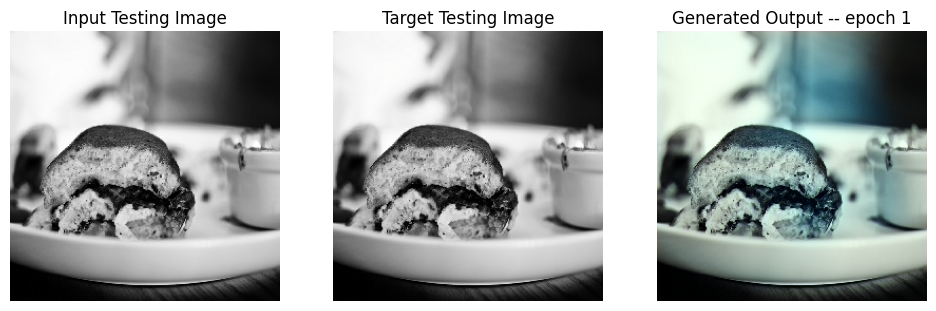

SSIM Score: 0.9702972769737244
PSNR Score: 26.542724609375
Epoch 1
Training Details
Generator-- total_loss:6.84776 gan_loss:1.03423 l1_loss:0.05028 perceptual_loss:0.00981 Discriminator-- total_loss:1.28533 real_loss:0.63006 generated_loss:0.65527 --- SSIM 0.00000 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 2 is 1501.9427843093872 sec
Number of iteration 1250
Validation Details
Generator-- total_loss:7.27297 gan_loss:0.94998 l1_loss:0.05371  perceptual_loss:0.01190 Discriminator-- total_loss:1.36125 real_loss:0.59261 generated_loss:0.76864 --- SSIM 0.87488 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 2 is 1603.1248178482056 sec
Number of iteration 157
Epoch 2
Training Details
Generator-- total_loss:6.89607 gan_loss:1.06524 l1_loss:0.05026 perceptual_loss:0.01006 Discriminator-- total_loss:1.25120 real_loss:0.60973 generated_loss:0.64147 --- SSIM 0.00000 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 3 is 1472.5667231082916 sec
Number of iteration 1250
Validation Details
Generat

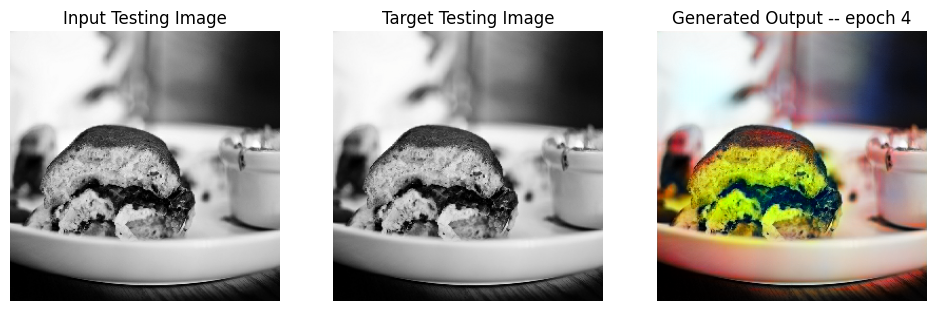

SSIM Score: 0.8864787220954895
PSNR Score: 17.634540557861328
Epoch 4
Training Details
Generator-- total_loss:6.80179 gan_loss:1.02298 l1_loss:0.04975 perceptual_loss:0.01005 Discriminator-- total_loss:1.25142 real_loss:0.60570 generated_loss:0.64572 --- SSIM 0.00000 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 5 is 1474.2241876125336 sec
Number of iteration 1250
Validation Details
Generator-- total_loss:6.83688 gan_loss:0.39911 l1_loss:0.05593  perceptual_loss:0.01056 Discriminator-- total_loss:1.86751 real_loss:1.52951 generated_loss:0.33800 --- SSIM 0.89629 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 5 is 1575.5455386638641 sec
Number of iteration 157
Epoch 5
Training Details
Generator-- total_loss:6.82253 gan_loss:1.04256 l1_loss:0.04965 perceptual_loss:0.01019 Discriminator-- total_loss:1.23589 real_loss:0.59802 generated_loss:0.63787 --- SSIM 0.00000 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 6 is 1476.9176142215729 sec
Number of iteration 1250
Validation Details
Gene

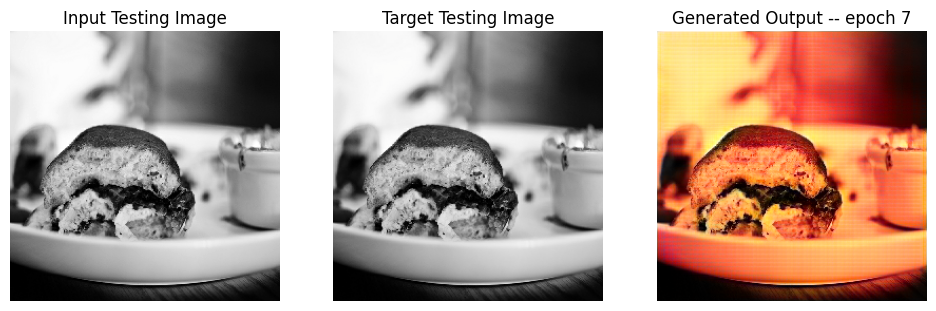

SSIM Score: 0.6372455954551697
PSNR Score: 10.999951362609863
Epoch 7
Training Details
Generator-- total_loss:6.81115 gan_loss:1.07039 l1_loss:0.04930 perceptual_loss:0.01014 Discriminator-- total_loss:1.20570 real_loss:0.58576 generated_loss:0.61994 --- SSIM 0.00000 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 8 is 1466.0524678230286 sec
Number of iteration 1250
Validation Details
Generator-- total_loss:10.01193 gan_loss:2.07982 l1_loss:0.06931  perceptual_loss:0.01252 Discriminator-- total_loss:1.51087 real_loss:0.27087 generated_loss:1.24000 --- SSIM 0.87596 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 8 is 1566.862708568573 sec
Number of iteration 157
Epoch 8
Training Details
Generator-- total_loss:6.81278 gan_loss:1.08644 l1_loss:0.04914 perceptual_loss:0.01016 Discriminator-- total_loss:1.20740 real_loss:0.58779 generated_loss:0.61961 --- SSIM 0.00000 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 9 is 1443.0466747283936 sec
Number of iteration 1250
Validation Details
Gene

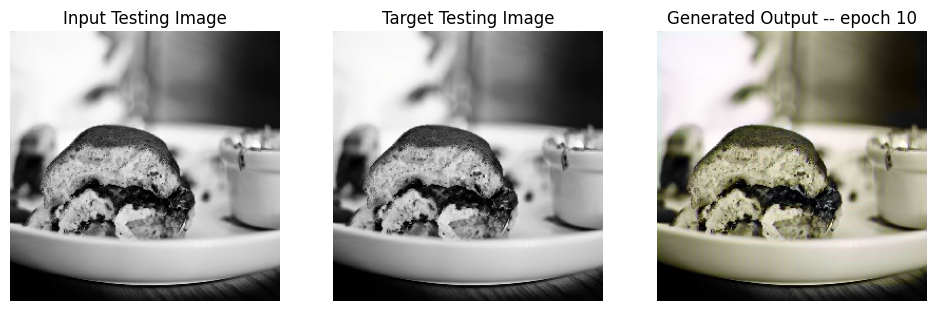

SSIM Score: 0.9688892364501953
PSNR Score: 26.87282943725586
Epoch 10
Training Details
Generator-- total_loss:5.03441 gan_loss:0.22814 l1_loss:0.04100 perceptual_loss:0.00883 Discriminator-- total_loss:2.41725 real_loss:1.99801 generated_loss:0.41924 --- SSIM 0.00000 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 11 is 1272.9960656166077 sec
Number of iteration 1250
Validation Details
Generator-- total_loss:5.60204 gan_loss:0.30369 l1_loss:0.04514  perceptual_loss:0.00980 Discriminator-- total_loss:2.11885 real_loss:1.46340 generated_loss:0.65546 --- SSIM 0.90579 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 11 is 1373.6078536510468 sec
Number of iteration 157
Epoch 11
Training Details
Generator-- total_loss:16.04859 gan_loss:11.23691 l1_loss:0.04109 perceptual_loss:0.00879 Discriminator-- total_loss:0.00660 real_loss:0.00351 generated_loss:0.00308 --- SSIM 0.00000 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 12 is 944.2196354866028 sec
Number of iteration 1250
Validation Details

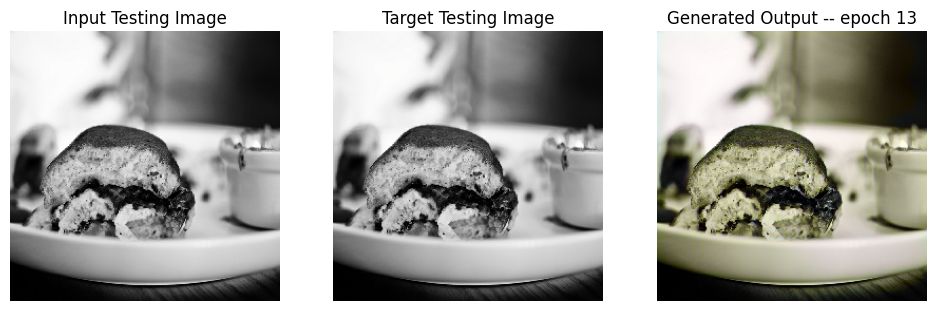

SSIM Score: 0.9690768718719482
PSNR Score: 26.134275436401367
Epoch 13
Training Details
Generator-- total_loss:15.86930 gan_loss:11.04120 l1_loss:0.04119 perceptual_loss:0.00886 Discriminator-- total_loss:0.00073 real_loss:0.00037 generated_loss:0.00037 --- SSIM 0.00000 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 14 is 946.2811527252197 sec
Number of iteration 1250
Validation Details
Generator-- total_loss:5.29792 gan_loss:0.02676 l1_loss:0.04490  perceptual_loss:0.00977 Discriminator-- total_loss:5.88435 real_loss:5.87206 generated_loss:0.01229 --- SSIM 0.90733 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 14 is 1046.4103362560272 sec
Number of iteration 157
Epoch 14
Training Details
Generator-- total_loss:17.85547 gan_loss:13.03426 l1_loss:0.04118 perceptual_loss:0.00879 Discriminator-- total_loss:0.00016 real_loss:0.00008 generated_loss:0.00008 --- SSIM 0.00000 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 15 is 954.1817398071289 sec
Number of iteration 1250
Validation Detai

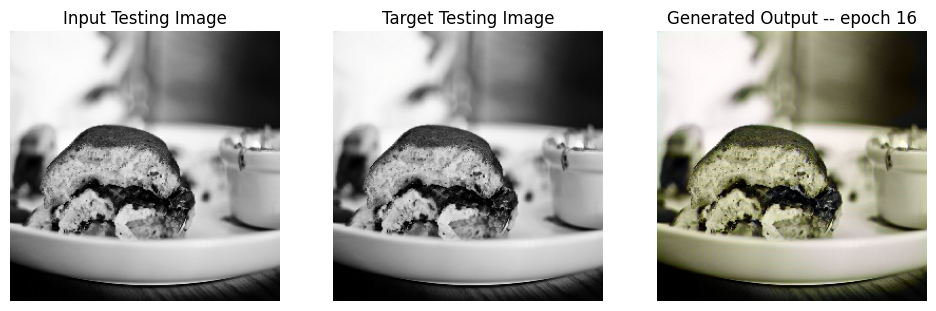

SSIM Score: 0.9683642387390137
PSNR Score: 26.099428176879883
Epoch 16
Training Details
Generator-- total_loss:19.02124 gan_loss:14.17741 l1_loss:0.04136 perceptual_loss:0.00884 Discriminator-- total_loss:0.00025 real_loss:0.00012 generated_loss:0.00013 --- SSIM 0.00000 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 17 is 967.1014740467072 sec
Number of iteration 1250
Validation Details
Generator-- total_loss:5.37236 gan_loss:0.00860 l1_loss:0.04566  perceptual_loss:0.00997 Discriminator-- total_loss:6.80365 real_loss:6.80071 generated_loss:0.00294 --- SSIM 0.90560 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 17 is 1070.3542966842651 sec
Number of iteration 157
Epoch 17
Training Details
Generator-- total_loss:20.88705 gan_loss:16.07279 l1_loss:0.04115 perceptual_loss:0.00874 Discriminator-- total_loss:0.00007 real_loss:0.00003 generated_loss:0.00003 --- SSIM 0.00000 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 18 is 1005.6701669692993 sec
Number of iteration 1250
Validation Deta

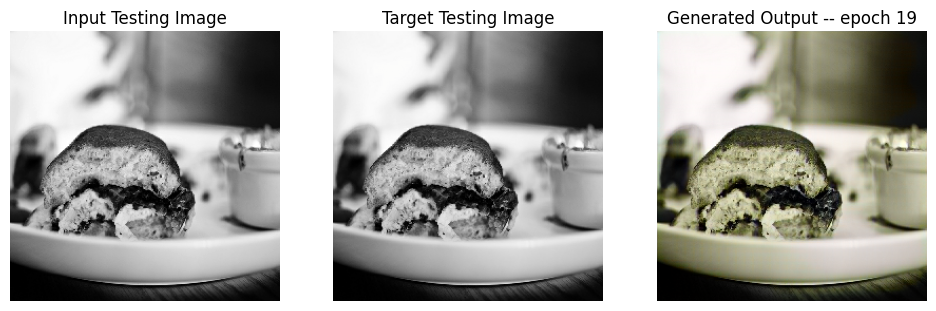

SSIM Score: 0.9694265723228455
PSNR Score: 26.19244956970215
Epoch 19
Training Details
Generator-- total_loss:23.83138 gan_loss:19.00188 l1_loss:0.04124 perceptual_loss:0.00882 Discriminator-- total_loss:0.00002 real_loss:0.00001 generated_loss:0.00001 --- SSIM 0.00000 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 20 is 1004.475811958313 sec
Number of iteration 1250
Validation Details
Generator-- total_loss:5.36135 gan_loss:0.00228 l1_loss:0.04564  perceptual_loss:0.00994 Discriminator-- total_loss:8.92057 real_loss:8.91957 generated_loss:0.00100 --- SSIM 0.90551 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 20 is 1104.7506363391876 sec
Number of iteration 157
Epoch 20
Training Details
Generator-- total_loss:24.98449 gan_loss:20.17926 l1_loss:0.04105 perceptual_loss:0.00875 Discriminator-- total_loss:0.00001 real_loss:0.00000 generated_loss:0.00000 --- SSIM 0.00000 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 21 is 953.6823134422302 sec
Number of iteration 1250
Validation Detail

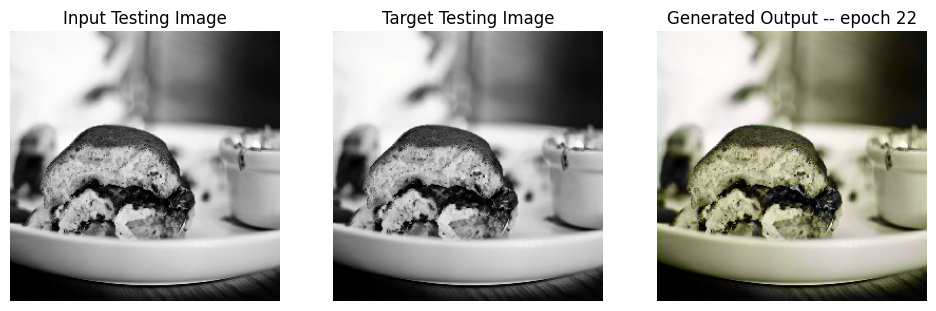

SSIM Score: 0.9685249328613281
PSNR Score: 26.067081451416016
Epoch 22
Training Details
Generator-- total_loss:25.83879 gan_loss:21.00359 l1_loss:0.04131 perceptual_loss:0.00880 Discriminator-- total_loss:0.00111 real_loss:0.00053 generated_loss:0.00058 --- SSIM 0.00000 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 23 is 955.5012545585632 sec
Number of iteration 1250
Validation Details
Generator-- total_loss:5.34787 gan_loss:0.00459 l1_loss:0.04560  perceptual_loss:0.00980 Discriminator-- total_loss:6.94490 real_loss:6.94181 generated_loss:0.00309 --- SSIM 0.90692 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 23 is 1055.2265691757202 sec
Number of iteration 157
Epoch 23
Training Details
Generator-- total_loss:27.32088 gan_loss:22.49562 l1_loss:0.04121 perceptual_loss:0.00880 Discriminator-- total_loss:0.00013 real_loss:0.00006 generated_loss:0.00007 --- SSIM 0.00000 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 24 is 962.0358700752258 sec
Number of iteration 1250
Validation Detai

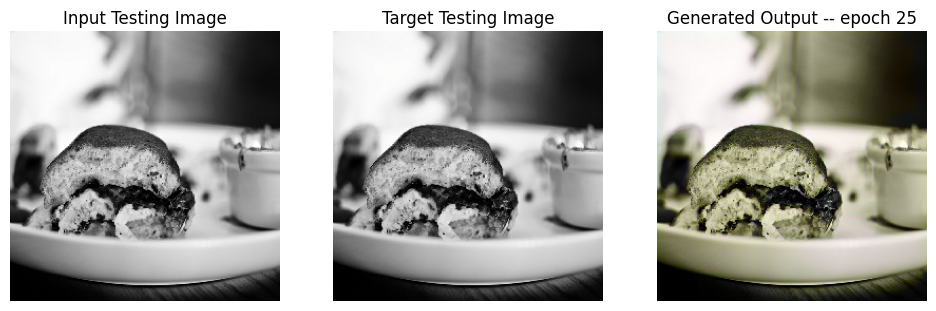

SSIM Score: 0.9685067534446716
PSNR Score: 26.04317855834961
Epoch 25
Training Details
Generator-- total_loss:29.67041 gan_loss:24.83856 l1_loss:0.04128 perceptual_loss:0.00880 Discriminator-- total_loss:0.00002 real_loss:0.00001 generated_loss:0.00001 --- SSIM 0.00000 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 26 is 950.6859972476959 sec
Number of iteration 1250
Validation Details
Generator-- total_loss:5.27907 gan_loss:0.00302 l1_loss:0.04492  perceptual_loss:0.00980 Discriminator-- total_loss:8.50342 real_loss:8.50172 generated_loss:0.00170 --- SSIM 0.90799 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 26 is 1053.434811115265 sec
Number of iteration 157
Epoch 26
Training Details
Generator-- total_loss:30.72826 gan_loss:25.89539 l1_loss:0.04124 perceptual_loss:0.00885 Discriminator-- total_loss:0.00001 real_loss:0.00000 generated_loss:0.00001 --- SSIM 0.00000 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 27 is 951.7975471019745 sec
Number of iteration 1250
Validation Details

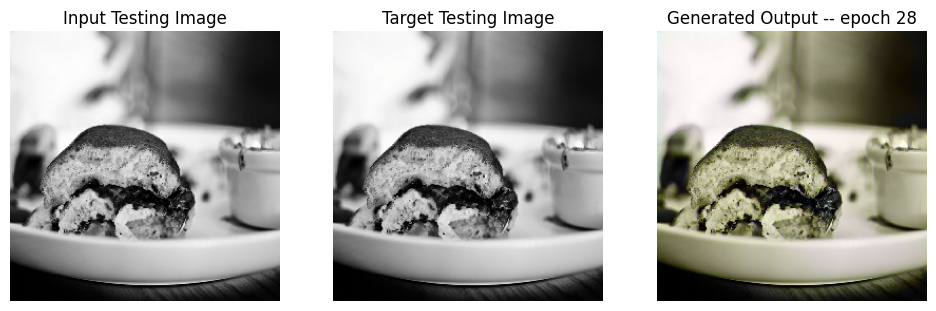

SSIM Score: 0.9690369963645935
PSNR Score: 26.16908836364746
Epoch 28
Training Details
Generator-- total_loss:43.02164 gan_loss:38.19965 l1_loss:0.04119 perceptual_loss:0.00879 Discriminator-- total_loss:0.00024 real_loss:0.00013 generated_loss:0.00012 --- SSIM 0.00000 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 29 is 951.0476694107056 sec
Number of iteration 1250
Validation Details
Generator-- total_loss:5.37152 gan_loss:0.02350 l1_loss:0.04549  perceptual_loss:0.00999 Discriminator-- total_loss:6.36130 real_loss:6.35323 generated_loss:0.00807 --- SSIM 0.90726 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 29 is 1052.1505281925201 sec
Number of iteration 157
Epoch 29
Training Details
Generator-- total_loss:43.63814 gan_loss:38.79107 l1_loss:0.04143 perceptual_loss:0.00880 Discriminator-- total_loss:0.00010 real_loss:0.00005 generated_loss:0.00005 --- SSIM 0.00000 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 30 is 951.4513125419617 sec
Number of iteration 1250
Validation Detail

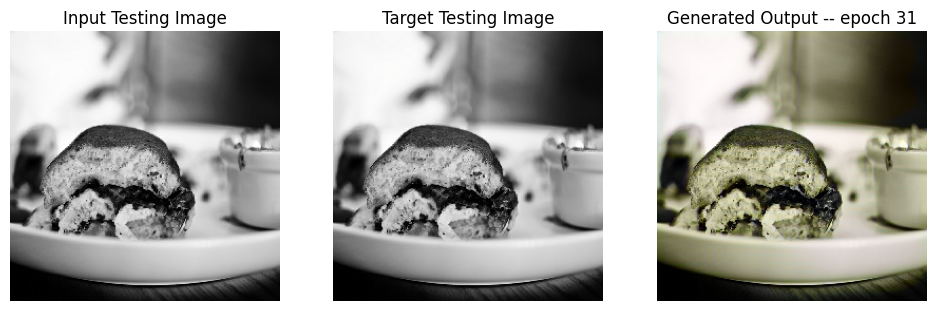

SSIM Score: 0.9684889912605286
PSNR Score: 26.07508659362793
Epoch 31
Training Details
Generator-- total_loss:44.28860 gan_loss:39.44143 l1_loss:0.04139 perceptual_loss:0.00886 Discriminator-- total_loss:0.00001 real_loss:0.00001 generated_loss:0.00001 --- SSIM 0.00000 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 32 is 956.3684759140015 sec
Number of iteration 1250
Validation Details
Generator-- total_loss:5.35632 gan_loss:0.00217 l1_loss:0.04561  perceptual_loss:0.00992 Discriminator-- total_loss:8.62801 real_loss:8.62529 generated_loss:0.00272 --- SSIM 0.90617 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 32 is 1055.5632643699646 sec
Number of iteration 157
Epoch 32
Training Details
Generator-- total_loss:44.43620 gan_loss:39.61161 l1_loss:0.04121 perceptual_loss:0.00880 Discriminator-- total_loss:0.00001 real_loss:0.00000 generated_loss:0.00000 --- SSIM 0.00000 PSNR 0.00000 LPIPS 0.00000
Time taken for epoch 33 is 954.4703226089478 sec
Number of iteration 1250
Validation Detail

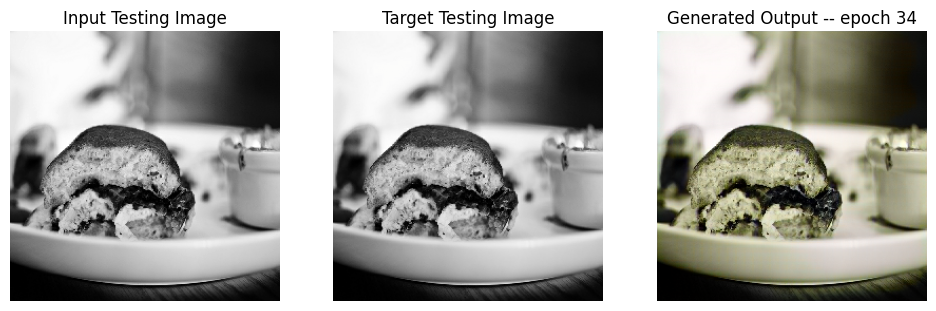

SSIM Score: 0.9688112139701843
PSNR Score: 26.078044891357422


In [50]:
fit(train_dataset, epochs, val, gen)

/tmp/ipykernel_26/1385076028.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-or" (-> color='r'). The keyword argument will take precedence.
  plt.plot(epochs, train_discriminator_losses, '-or', color='orange', label='Discriminator Loss')


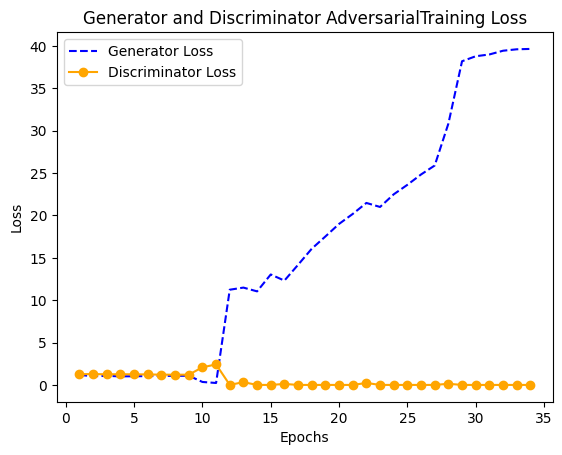

In [51]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_gan_losses, '--b', label='Generator Loss')
plt.plot(epochs, train_discriminator_losses, '-or', color='orange', label='Discriminator Loss')
plt.title('Generator and Discriminator AdversarialTraining Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/train_loss_plot_1.png')
plt.show()

/tmp/ipykernel_26/4010479747.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-or" (-> color='r'). The keyword argument will take precedence.
  plt.plot(epochs, test_discriminator_losses, '-or', color='orange', label='Discriminator Loss')


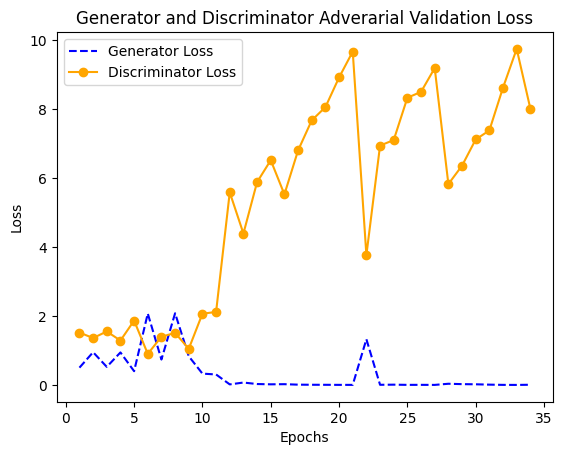

In [52]:
epochs = range(1, len(test_generator_losses) + 1)

plt.plot(epochs, test_generator_gan_losses, '--b', label='Generator Loss')
plt.plot(epochs, test_discriminator_losses, '-or', color='orange', label='Discriminator Loss')
plt.title('Generator and Discriminator Adverarial Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/test_loss_plot_1.png')
plt.show()

/tmp/ipykernel_26/825315398.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-or" (-> color='r'). The keyword argument will take precedence.
  plt.plot(epochs, testing_ssim, '-or', color='orange', label='Validation SSIM')


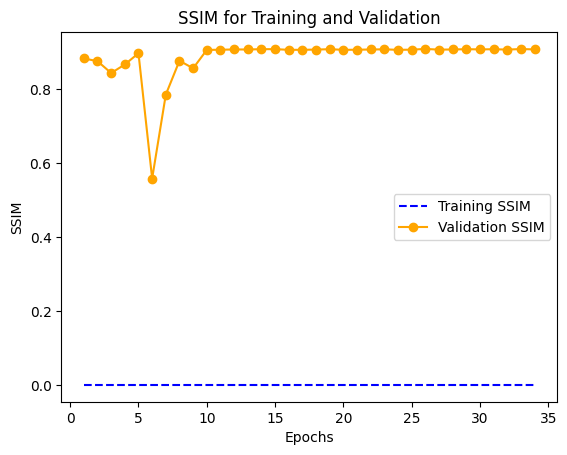

In [53]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, training_ssim, '--b', label='Training SSIM')
plt.plot(epochs, testing_ssim, '-or', color='orange', label='Validation SSIM')
plt.title('SSIM for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.legend()
plt.savefig('/kaggle/working/SSIM_plot_1.png')
plt.show()

/tmp/ipykernel_26/1818322218.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-or" (-> color='r'). The keyword argument will take precedence.
  plt.plot(epochs, testing_psnr, '-or', color='orange', label='Validation PSNR')


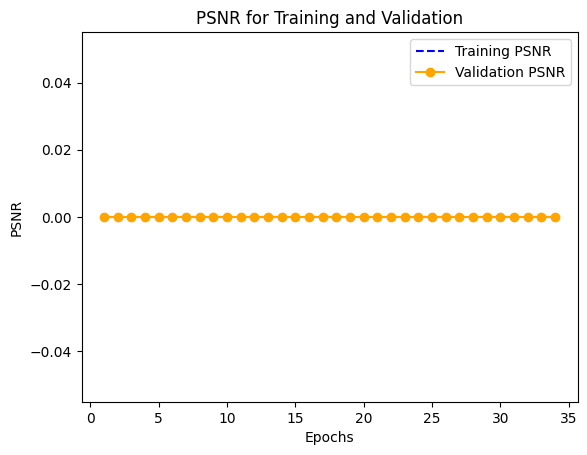

In [54]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, training_psnr, '--b', label='Training PSNR')
plt.plot(epochs, testing_psnr, '-or', color='orange', label='Validation PSNR')
plt.title('PSNR for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.legend()
plt.savefig('/kaggle/working/PSNR_plot_1.png')
plt.show()

/tmp/ipykernel_26/136468053.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-or" (-> color='r'). The keyword argument will take precedence.
  plt.plot(epochs, testing_lpips, '-or', color='orange', label='Validation LPIPS')


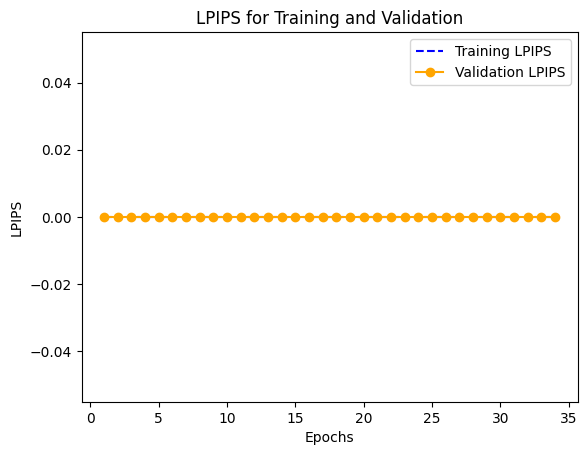

In [55]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, training_lpips, '--b', label='Training LPIPS')
plt.plot(epochs, testing_lpips, '-or', color='orange', label='Validation LPIPS')
plt.title('LPIPS for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('LPIPS')
plt.legend()
plt.savefig('/kaggle/working/LPIPS_plot_1.png')
plt.show()

/tmp/ipykernel_26/3235268261.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-or" (-> color='r'). The keyword argument will take precedence.
  plt.plot(epochs, test_generator_gan_losses,'-or', color='orange', label='Validation_Generator_GAN_Loss')


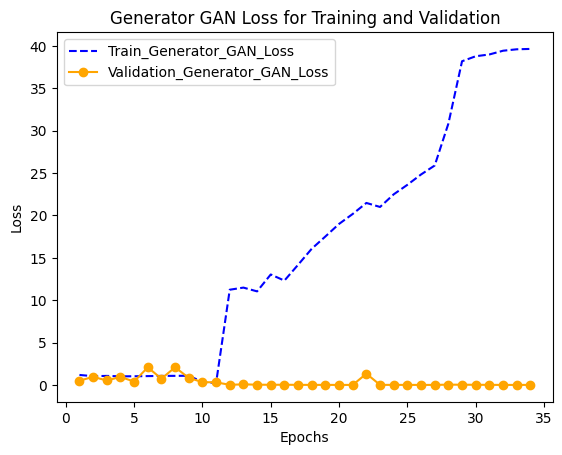

In [56]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_gan_losses, '--b', label='Train_Generator_GAN_Loss')
plt.plot(epochs, test_generator_gan_losses,'-or', color='orange', label='Validation_Generator_GAN_Loss')
plt.title('Generator GAN Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Gen_GAN_plot_1.png')
plt.show()

/tmp/ipykernel_26/271018654.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-or" (-> color='r'). The keyword argument will take precedence.
  plt.plot(epochs, test_generator_l1_losses, '-or', color='orange', label='Validation_Generator_L1_Loss')


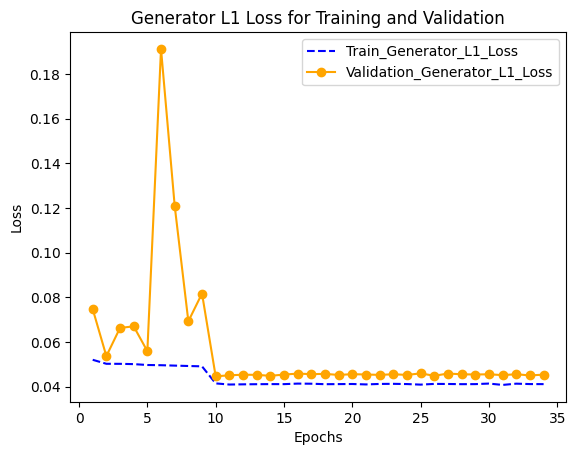

In [57]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_l1_losses, '--b', label='Train_Generator_L1_Loss')
plt.plot(epochs, test_generator_l1_losses, '-or', color='orange', label='Validation_Generator_L1_Loss')
plt.title('Generator L1 Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Gen_L1_plot_1.png')
plt.show()

/tmp/ipykernel_26/1114805691.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-or" (-> color='r'). The keyword argument will take precedence.
  plt.plot(epochs, test_generator_perceptual_losses, '-or', color='orange', label='Validation_Generator_Perceptual_Loss')


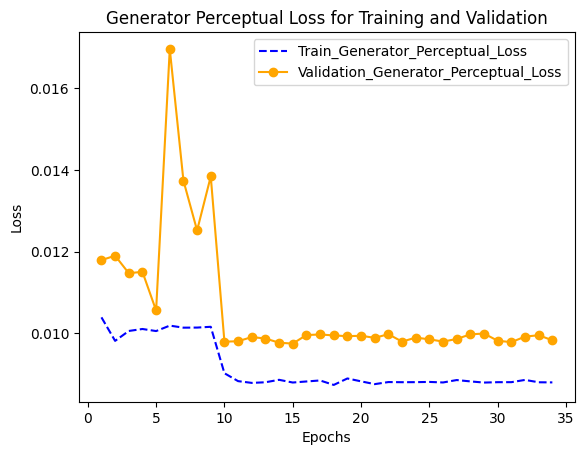

In [58]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_perceptual_losses, '--b', label='Train_Generator_Perceptual_Loss')
plt.plot(epochs, test_generator_perceptual_losses, '-or', color='orange', label='Validation_Generator_Perceptual_Loss')
plt.title('Generator Perceptual Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Gen_Perceptual_plot_1.png')
plt.show()

/tmp/ipykernel_26/1582919640.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-or" (-> color='r'). The keyword argument will take precedence.
  plt.plot(epochs, test_generator_losses, '-or', color='orange', label='Validation_Generator_Loss')


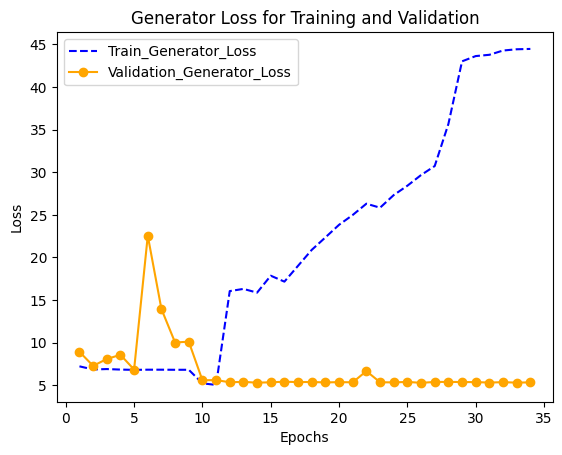

In [59]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_losses, '--b', label='Train_Generator_Loss')
plt.plot(epochs, test_generator_losses, '-or', color='orange', label='Validation_Generator_Loss')
plt.title('Generator Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Gen_plot_1.png')
plt.show()

/tmp/ipykernel_26/1374437368.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-or" (-> color='r'). The keyword argument will take precedence.
  plt.plot(epochs, test_discriminator_losses, '-or', color='orange', label='Validation_Discriminator_Loss')


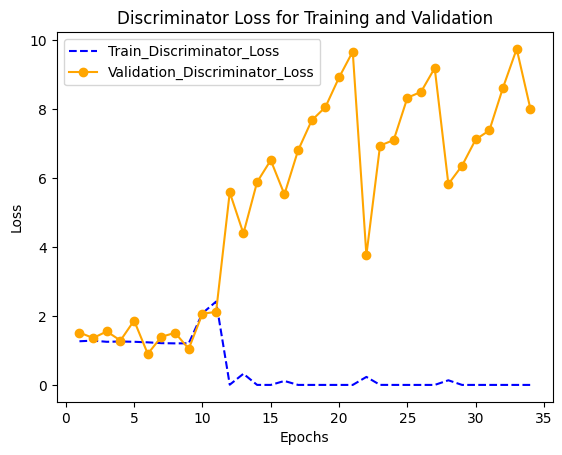

In [60]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_discriminator_losses, '--b', label='Train_Discriminator_Loss')
plt.plot(epochs, test_discriminator_losses, '-or', color='orange', label='Validation_Discriminator_Loss')
plt.title('Discriminator Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Disc_plot_1.png')
plt.show()

/tmp/ipykernel_26/1497767744.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-or" (-> color='r'). The keyword argument will take precedence.
  plt.plot(epochs, test_discriminator_real_losses, '-or', color='orange', label='Validation_Discriminator_Real_Loss')


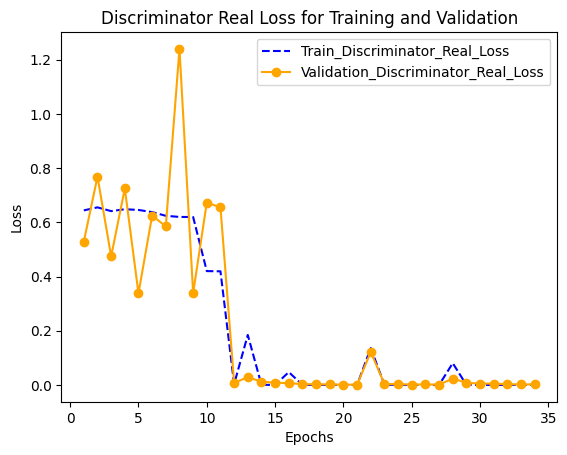

In [61]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_discriminator_real_losses, '--b', label='Train_Discriminator_Real_Loss')
plt.plot(epochs, test_discriminator_real_losses, '-or', color='orange', label='Validation_Discriminator_Real_Loss')
plt.title('Discriminator Real Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Disc_Real_plot_1.png')
plt.show()

/tmp/ipykernel_26/1197813443.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-or" (-> color='r'). The keyword argument will take precedence.
  plt.plot(epochs, test_discriminator_generated_losses,'-or', color='orange', label='Validation_Discriminator_Generated_Loss')


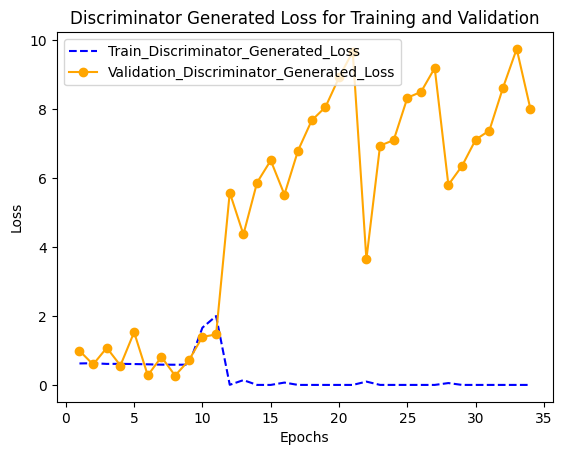

In [62]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_discriminator_generated_losses, '--b', label='Train_Discriminator_Generated_Loss')
plt.plot(epochs, test_discriminator_generated_losses,'-or', color='orange', label='Validation_Discriminator_Generated_Loss')
plt.title('Discriminator Generated Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Disc_Generated_plot_1.png')
plt.show()

In [63]:
import csv
with open('/kaggle/working/dataJan20.csv','w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(all_records)

In [64]:
# # Evaluation on testing data


# each_epoch_test_lpips = []
# each_epoch_test_psnr = []
# each_epoch_test_ssim = []
# each_epoch_test_fid = []
# each_epoch_test_generator_losses = []
# each_epoch_test_generator_gan_losses = []
# each_epoch_test_generator_l1_losses = []
# each_epoch_test_generator_l2_losses = []
# each_epoch_test_generator_perceptual_losses = []
# each_epoch_test_discriminator_losses = []
# each_epoch_test_discriminator_real_losses = []
# each_epoch_test_discriminator_generated_losses = []

# for n, (input_, target) in test_dataset.enumerate():
#     test_gen_loss, test_gen_gan_loss, test_gen_l1_loss, test_gen_perceptual_loss, test_disc_loss, test_disc_real_loss, test_disc_generated_loss, test_ssim, test_psnr, test_lpips, test_fid = test_step(input_, target)

#     each_epoch_test_generator_losses.append(test_gen_loss)
#     each_epoch_test_generator_gan_losses.append(test_gen_gan_loss)
#     each_epoch_test_generator_l1_losses.append(test_gen_l1_loss)
# #             each_epoch_test_generator_l2_losses.append(test_gen_l2_loss)
#     each_epoch_test_generator_perceptual_losses.append(test_gen_perceptual_loss)
#     each_epoch_test_discriminator_losses.append(test_disc_loss)
#     each_epoch_test_discriminator_real_losses.append(test_disc_real_loss)
#     each_epoch_test_discriminator_generated_losses.append(test_disc_generated_loss)
#     each_epoch_test_ssim.append(tf.reduce_mean(test_ssim.numpy()))
#     each_epoch_test_psnr.append(tf.reduce_mean(test_psnr.numpy()))
#     each_epoch_test_lpips.append(tf.reduce_mean(test_lpips.numpy()))
#     each_epoch_test_fid.append(test_fid)
#     print(test_fid)

# print("Testing Details")
# print("Generator-- total_loss:{:.5f} gan_loss:{:.5f} l1_loss:{:.5f}  perceptual_loss:{:.5f} \nDiscriminator-- total_loss:{:.5f} real_loss:{:.5f} generated_loss:{:.5f} --- \nSSIM {:.5f} \nPSNR {:.5f} \nLPIPS {:.5f} \nFID Score: {:.5f}".format(np.mean(each_epoch_test_generator_losses),np.mean(each_epoch_test_generator_gan_losses), np.mean(each_epoch_test_generator_l1_losses), np.mean(each_epoch_test_generator_perceptual_losses),np.mean(each_epoch_test_discriminator_losses), np.mean(each_epoch_test_discriminator_generated_losses), np.mean(each_epoch_test_discriminator_real_losses), np.mean(each_epoch_test_ssim), np.mean(each_epoch_test_psnr), np.mean(each_epoch_test_lpips), np.mean(each_epoch_test_fid)))

In [65]:
os.mkdir('/kaggle/working/modelsFeb7')

In [66]:
gen.save('/kaggle/working/modelsFeb7/gen.h5')
gen.save_weights('/kaggle/working/modelsFeb7/gen_weight.keras')
disc.save('/kaggle/working/modelsFeb7/disc.h5')
disc.save_weights('/kaggle/working/modelsFeb7/disc_wweight.keras')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [67]:
def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode !=0:
        print("Unable to run zip command")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [68]:
import subprocess
from IPython.display import FileLink, display

In [69]:
download_file('/kaggle/working', 'outputFeb10')

/kaggle/working/outputFeb10.zip